In [3]:
%reset
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy.signal import butter, lfilter, freqz

train1 = pd.read_csv('train_dataset01.csv')
train2 = pd.read_csv('train_dataset02.csv')
test = pd.read_csv('test_dataset.csv')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
train2.head()

,DATETIME,LEVEL_T1,LEVEL_T2,LEVEL_T3,LEVEL_T4,LEVEL_T5,LEVEL_T6,LEVEL_T7,PRESSURE_J280,PRESSURE_J269,...,STATUS_PU4,STATUS_PU5,STATUS_PU6,STATUS_PU7,STATUS_PU8,STATUS_PU9,STATUS_PU10,STATUS_PU11,STATUS_V2,ATT_FLAG
0,2016-02-04 05:00:00,1.40,3.81,4.96,4.04,4.5,5.02,2.71,2.98,35.33,...,False,False,False,True,True,False,True,False,True,False
1,2016-02-04 05:15:00,1.45,3.89,4.91,4.16,4.5,5.11,2.94,2.98,35.36,...,False,False,False,True,True,False,True,False,True,False
2,2016-02-04 05:30:00,1.49,3.97,4.85,4.29,4.5,5.20,3.17,2.98,35.39,...,False,False,False,True,True,False,True,False,True,False
3,2016-02-04 05:45:00,1.53,4.05,4.80,4.42,4.5,5.30,3.40,2.98,35.41,...,False,False,False,True,True,False,True,False,True,False
4,2016-02-04 06:00:00,1.57,4.12,4.74,4.55,4.5,5.39,3.63,2.98,35.32,...,False,False,False,False,True,False,True,False,True,False


In [5]:
# Function to create new features
def make_new_features(data, fluc_window, MA_window, above_window, means):
    """
    Fluctions refer to the sum of differences
    between each row and its previous row in a window
    """
    numerics = data.select_dtypes(include="float64")
    
    # Calculate fluctuations
    flucs = numerics.diff()
    flucs = flucs.abs()
    flucs = flucs.rolling(fluc_window).sum()
    flucs = flucs.fillna(0)
    flucs.columns = [str(col) + '_delta_t' for col in flucs.columns]
    
    # Calculate Moving Average
    ma = numerics.rolling(MA_window).mean()
    ma = ma.fillna(numerics.mean())
    ma.columns = [str(col) + '_MA' for col in ma.columns]
    
    # Count number of obs above mean in a window
    above = numerics > means
    above = above.rolling(above_window).sum()
    above = above.fillna(above.mean())
    above.columns = [str(col) + '_above' for col in above.columns]
    
    # Create output
    out = pd.concat([data.reset_index(drop=True), flucs], axis=1)
    out = pd.concat([out.reset_index(drop=True), ma], axis=1)
    out = pd.concat([out.reset_index(drop=True), above], axis=1)

    return out


In [6]:
# Function to calculate p-value for every obs
def make_p_values(data, means, stds):
    """
    Calculate p-value for all obs for all numeric 
    features
    """
    numeric_cols = data.select_dtypes(include="float64").columns
    new_cols = []
    for col in numeric_cols:
        new_col = col + "_p"
        
        # Calculate p-values
        data[new_col] = data[col].apply(stats.norm.cdf, 
                                        args=(means[col], stds[col]))
        
        # Make values between 0 and 0.5
        data[new_col] = np.where(data[new_col] <= 0.5, data[new_col], 1 - data[new_col])
        data[new_col] = data[new_col].fillna(0.5)
        new_cols.append(new_col)

    return new_cols
        

In [7]:
# Function to vote anomalies from p-values
def create_votes(data, p_cols, threshold):
    """
    For each p-value column, add 1 vote if p-value below threshold
    Votes decide whether an obs is an anomaly
    """
    temp = data[test_p_cols] < threshold
    data["votes"] = temp.sum(axis=1)


In [8]:
# Function to get scores from votes
def create_scores(data, alpha):
    """
    Create score from votes
    Each score depends on all previous scores
    """
    scores = []
    for i in range(len(data["votes"])):
        if i > 1:
            score = alpha*scores[i-1] + data["votes"][i]
        else:
            score = data["votes"][i]
        scores.append(score)
    return scores


In [9]:
# Function to change scores to ATT_FLAG
def create_ATT_FLAG(data, scores, min_votes):
    """
    Create dataframe in submission format
    """
    temp = np.asarray(scores)

    out = data[["DATETIME"]].copy()
    out["ATT_FLAG"] = np.where(temp >= min_votes, 1, 0)

    return out


In [10]:
def frange(x, y, jump):
    """
    range for floats
    """
    while x < y:
        yield x
        x += jump


In [11]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [12]:
def filter_data(data,sampleRate,cutoff,order):
    # utilise low pass filter
    nyq = 0.5 * sampleRate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    numerics = data.select_dtypes(include="float64")
    
    # include filter
    filterData = numerics
    columns = filterData.columns
    filterData = pd.DataFrame(lfilter(b, a, filterData))
    filterData.columns = [str(col) + '_filter' for col in columns]
    
    out = pd.concat([data.reset_index(drop=True), filterData], axis=1)
    return out

In [13]:
# Learn mean and std from no attack data
no_attacks = train2[~train2.ATT_FLAG]
means = no_attacks.mean()
stds = no_attacks.std()

# Process train2
train2 = make_new_features(train2, 10, 10, 20, means)

# Process test
test = make_new_features(test, 10, 10, 20, means)

In [14]:
# Filter train2 
train2 = filter_data(train2,10,3,4)

# Filter test 
test= filter_data(test,10,3,4)

# Update mean and std with new features 
no_attacks = train2[~train2.ATT_FLAG]
means = no_attacks.mean()
stds = no_attacks.std()

# Make p-value columns
train_p_cols = make_p_values(train2, means, stds)
test_p_cols = make_p_values(test, means, stds)

In [32]:
# Grid Search for best p-value threshold, decay rate and min_vote
bestF1 = 0
bestP = 0
bestAlpha = 0
bestMinVotes = 0
y_true = train2.ATT_FLAG

for iteration in log_progress(range(30), every=1):
    p = 0.003 + iteration*0.0001
    create_votes(train2, train_p_cols, p)

    for alpha in frange(0.94, 0.99, 0.002):
        train2_scores = create_scores(train2, alpha)

        for min_votes in range(90, 115):            
            train2_out = create_ATT_FLAG(train2, train2_scores, min_votes)

            # Calculate F score in train2
            y_pred = train2_out.ATT_FLAG == 1
            f1 = f1_score(y_true, y_pred)
            
            if f1 > bestF1:
                bestF1 = f1
                bestP = p
                bestAlpha = alpha
                bestMinVotes = min_votes
                
print(bestF1, bestP, bestAlpha, bestMinVotes)
# 0.7352320675105484 0.015 0.9700000000000004 94 with fluc (0.015 P was my lower bound)
# 0.7512520868113522 0.012 0.9550000000000002 96 with fluc and ma (0.012 P was my lower bound)
# 0.7804999999999999 0.006 0.9700000000000001 99 with fluc, ma and above (0.005 P was my lower bound)
# 0.7815978233984665 0.0057 0.969 91 with fluc, ma and above (0.005 P was my lower bound)
# with 30 as sampleRate -> 0.77 
# with 40 as sampleRate -> 0.7760567077973222
# with 20 as sampleRate -> 0.7959866220735786 0.0031 0.962 113
# with 7 as sampleRate -> 0.7951207368683096 0.0034000000000000002 0.964 112

0.8050000000000002 0.003 0.962 110


In [15]:
create_votes(test, test_p_cols, 0.003)

In [16]:
test_scores = create_scores(test, 0.962)

In [17]:
test_out = create_ATT_FLAG(test, test_scores, 110)

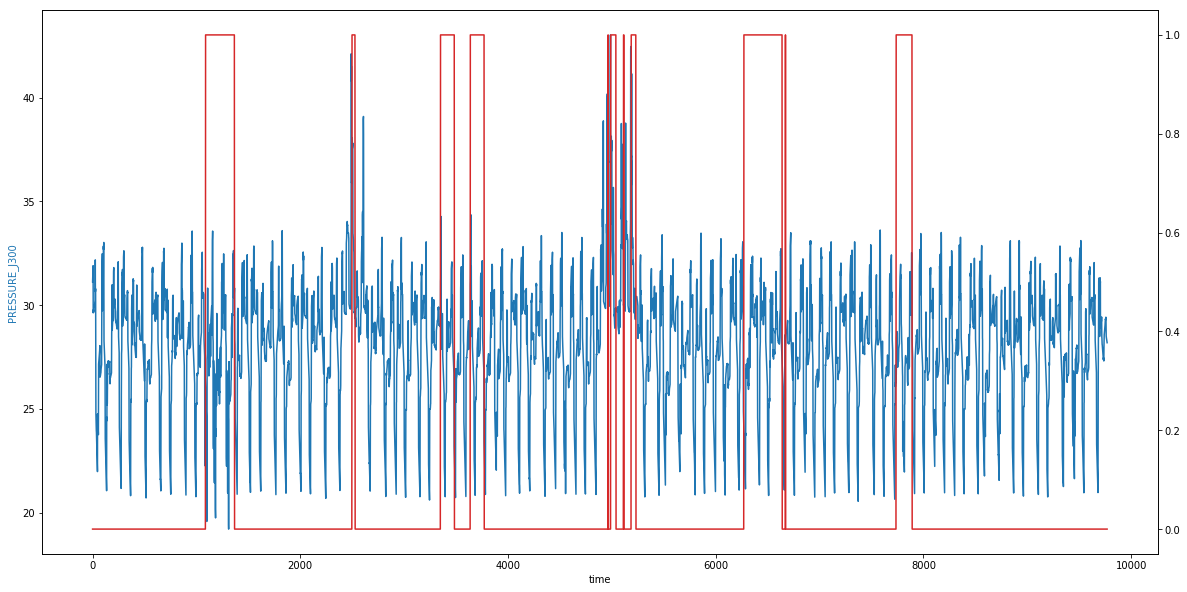

In [18]:
# Plot
fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:blue'
ax1.set_xlabel('time')
ax1.set_ylabel('PRESSURE_J300', color=color)
ax1.plot(test['PRESSURE_J300'], color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.plot(test_out['ATT_FLAG'], color=color)

plt.show()

In [19]:
test_out["ATT_FLAG"] = test_out["ATT_FLAG"].astype('bool')
test_out.head()

,DATETIME,ATT_FLAG
0,2016-09-18 04:45:00,False
1,2016-09-18 05:00:00,False
2,2016-09-18 05:15:00,False
3,2016-09-18 05:30:00,False
4,2016-09-18 05:45:00,False


In [21]:
# check against eyeball
eyeball = pd.read_csv("eyeball.csv")
y_pred = test_out["ATT_FLAG"]
y_true = eyeball["ATT_FLAG"]
f1 = f1_score(y_true, y_pred)

f1

0.7248730964467005

In [39]:
# test_out.to_csv("output4.csv", index=False)